In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy.ctypeslib as npct
from ctypes import c_int, c_double, c_float
import h5py


#=================================================================================
array_3d_float = npct.ndpointer(dtype=np.float64, ndim=3, flags='CONTIGUOUS')
array_1d_float = npct.ndpointer(dtype=np.float64, ndim=1, flags='CONTIGUOUS')

libenergyev = npct.load_library("/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/energy_dens_ev/KHI/lib_new_gamma", ".")
libenergyev.energy_ev_khi.restype = None
libenergyev.energy_ev_khi.argtypes = [c_double, c_int, c_double, c_double, c_double,array_1d_float, array_1d_float, array_1d_float, array_1d_float]
#=================================================================================

In [2]:
def read_growth(arx):

    with h5py.File(arx, "r") as f:
    # List all groups
        g_khi = np.array(f.get('growth'))

        time = np.array(f.get('time'))

        f.close()

    return g_khi

def readh5files(arx): 
#    print('DATA FROM FILE:      ',arx)

    with h5py.File(arx, "r") as f:
      # List all groups
     #   print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())

        Sf = np.array(f.get('S_f'))
        x = np.array(f.get('x'))
        y = np.array(f.get('y'))
        z = np.array(f.get('z'))
        xf = np.array(f.get('x_f'))
        yf = np.array(f.get('y_f'))
        zf = np.array(f.get('z_f'))
        rho = np.array(f.get('rho_mean'))
        Mxx = np.array(f.get('stress_Mxx'))
        Mxy = np.array(f.get('stress_Mxy'))
        Mxz = np.array(f.get('stress_Mxz'))
        Myy = np.array(f.get('stress_Myy'))
        Myz = np.array(f.get('stress_Myz'))
        Mzz = np.array(f.get('stress_Mzz'))
        Rxx = np.array(f.get('stress_Rxx'))
        Rxy = np.array(f.get('stress_Rxy'))
        Rxz = np.array(f.get('stress_Rxz'))
        Ryy = np.array(f.get('stress_Ryy'))
        Ryz = np.array(f.get('stress_Ryz'))
        Rzz = np.array(f.get('stress_Rzz'))
        Fxx = np.array(f.get('stress_Fxx'))
        Fxy = np.array(f.get('stress_Fxy'))
        Fxz = np.array(f.get('stress_Fxz'))
        Fyx = np.array(f.get('stress_Fyx'))
        Fyy = np.array(f.get('stress_Fyy'))
        Fyz = np.array(f.get('stress_Fyz'))
        Fzx = np.array(f.get('stress_Fzx'))
        Fzy = np.array(f.get('stress_Fzy'))
        Fzz = np.array(f.get('stress_Fzz'))

        time = np.array(f.get('time'))

        f.close()
  
    M = np.array([Mxx,Mxy,Mxz,Myy,Myz,Mzz])
    R = np.array([Rxx,Rxy,Rxz,Ryy,Ryz,Rzz])
    F = np.array([Fyx-Fxy,Fzx-Fxz,Fzy-Fyz])
  
#    print('Dimensions of the grid     :',len(x)," x ",len(y)," x ",len(z))
    print('Time           :',time)
  
    return [M, R, F, rho, x, y, z, xf, yf, zf]

def energy_ev(Sf,sc,t,factor_c, energy_ini,gamma,fac_gamma,rho,esim):

    timestep = 5e-5
    tfinal = t[-1]
    lent = int(round((tfinal-t[0])/timestep))+1
    tnew = np.linspace(t[0],tfinal,lent)

    interpg = interpolate.interp1d(t, gamma*fac_gamma, kind = "cubic")
    gamma_khi = interpg(tnew)
    std_fact = factor_c/(rho**(0.5)*sc)
    
    interpsim = interpolate.interp1d(t, esim, kind = "cubic")
    eint = interpsim(tnew)

    energy_t = np.zeros(lent)
    der = np.zeros(lent)
    energy_t[0] = energy_ini
    libenergyev.energy_ev_khi(std_fact,lent,float(20),float(Sf),timestep,gamma_khi, energy_t,der,eint)

    ratio = int((lent-1)/(len(t)-1))
    energy_model = np.zeros(len(t))
    deren = np.zeros(len(t))

    for i in range(0,len(t)-1):
        energy_model[i] = energy_t[ratio*i]
        deren[i] = der[ratio*i]
    energy_model[-1] = energy_t[-1]
    deren[-1] = der[-1]

    return energy_model, gamma_khi, std_fact, deren


In [3]:
bx0 = '3e-4'
leng = 256
res = str(leng)+'_'+str(leng)+'_'+str(leng)
#Sf = ['30','40','48','50','56','60','70','80','90','105','115']
#Sf = ['30','40','48','50','56','60','70','80']
Sf = ['20','24','28']
path_data = "/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_"+res+"/CVP--bx"+bx0+"--"+str(leng)+"--rndom"

In [4]:
t_final = 40
lent = 401
ind = 0
indf = 402
told = np.linspace(0,t_final,lent)
ind0 = 0
told = told[ind0:]
ind = ind-ind0
indf = indf-ind0
t = told[ind:indf]
lent = len(t)

timestep = 5e-5
tfinal = t[-1]
lentnew = int(round((tfinal-t[0])/timestep))+1
tnew = np.linspace(t[0],tfinal,lentnew)
    
Msim = np.zeros((3,lent,6,15,2,15))
Rsim = np.zeros((3,lent,6,15,2,15))
Fsim = np.zeros((3,lent,3,15,2,15))
rhomean = np.zeros((3,lent,15,2,15))
g_khi= np.zeros((3,len(told),15,2,15))
gmod = np.zeros((3,len(tnew),15,2,15))
std = np.zeros((3,15,2,15))
deren = np.zeros((3,len(told),15,2,15))
ekhi = np.zeros((3,lent,15,2,15))
energyKHI= []

for i,ss in enumerate(Sf):
    inivars = readh5files(path_data+'/results/stress_tensors/Sf_'+ss+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-0000.h5')

    xfilter = inivars[7]
    yfilter = inivars[8]
    zfilter = inivars[9]
    
    enKHImod= np.zeros((len(told), len(xfilter), len(yfilter), len(zfilter)))

    sf = '20'
    
    for tt in range(0, lent):        
        arx = format(int(10*t[tt]), "04")
        Msim[i,tt], Rsim[i,tt], Fsim[i,tt], rhomean[i,tt], x, y, z, xfilter, yfilter, zfilter = readh5files(path_data+'/results/stress_tensors/Sf_'+ss+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-'+arx+'.h5')

    for tt in range(0,len(told)):
        arx = format(int(10*told[tt]), "04")
        tmp_g = read_growth(path_data+'/results/growth_rates/Sf_'+ss+'/growth--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-'+arx+'.h5')
     #   g_khi[i,tt] = tmp_g*(int(ss)/int(sf))**(-2/3)
        g_khi[i,tt] = tmp_g
     
    ekhi[i]  = 0.5*rhomean[i]*(Rsim[i,:,0,:,:,:]+Rsim[i,:,3,:,:,:]+Rsim[i,:,5,:,:,:])
    
    var0 = readh5files(path_data+'/results/stress_tensors/Sf_'+ss+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-0000.h5')
    rho0 = var0[3]
    Rsim0 = var0[1]
    
    ekhi0  = 0.5*rho0*(Rsim0[0,:,:,:]+Rsim0[3,:,:,:]+Rsim0[5,:,:,:])
 #   ekhi0  = 0.5*rho0*(Rsim0[0,:,:,:]+Rsim0[3,:,:,:]+Rsim0[5,:,:,:])*(int(ss)/int(sf))**(2/3)

#    var0 = readh5files(path_data+'/results/stress_tensors/Sf_'+sf+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+sf+'-0020.h5')
#    rho0 = var0[3]
    
    cellsize = x[1]-x[0]

    filtersize = int(ss)*cellsize
    scale = 15.8*filtersize 

    for j in range(0,len(xfilter)):

        for k in range(0,len(yfilter)):

            for l in range(0,len(zfilter)):

                enKHImod[:,j,k,l], gmod[i,:,j,k,l], std[i,j,k,l], deren[i,:,j,k,l] = energy_ev(int(ss),scale,told, 10, ekhi0[j,k,l],g_khi[i,:,j,k,l],0.14,rho0[j,k,l],ekhi[i,:,j,k,l])
                
    energyKHI.append(enKHImod)

Time           : 0.0
Time           : 0.0
Time           : 0.1
Time           : 0.2
Time           : 0.30000000000000004
Time           : 0.4
Time           : 0.5
Time           : 0.6000000000000001
Time           : 0.7000000000000001
Time           : 0.8
Time           : 0.9
Time           : 1.0
Time           : 1.1
Time           : 1.2000000000000002
Time           : 1.3
Time           : 1.4000000000000001
Time           : 1.5
Time           : 1.6
Time           : 1.7000000000000002
Time           : 1.8
Time           : 1.9000000000000001
Time           : 2.0
Time           : 2.1
Time           : 2.2
Time           : 2.3000000000000003
Time           : 2.4000000000000004
Time           : 2.5
Time           : 2.6
Time           : 2.7
Time           : 2.8000000000000003
Time           : 2.9000000000000004
Time           : 3.0
Time           : 3.1
Time           : 3.2
Time           : 3.3000000000000003
Time           : 3.4000000000000004
Time           : 3.5
Time           : 3.6
Time  

Time           : 32.4
Time           : 32.5
Time           : 32.6
Time           : 32.7
Time           : 32.800000000000004
Time           : 32.9
Time           : 33.0
Time           : 33.1
Time           : 33.2
Time           : 33.300000000000004
Time           : 33.4
Time           : 33.5
Time           : 33.6
Time           : 33.7
Time           : 33.800000000000004
Time           : 33.9
Time           : 34.0
Time           : 34.1
Time           : 34.2
Time           : 34.300000000000004
Time           : 34.4
Time           : 34.5
Time           : 34.6
Time           : 34.7
Time           : 34.800000000000004
Time           : 34.9
Time           : 35.0
Time           : 35.1
Time           : 35.2
Time           : 35.300000000000004
Time           : 35.4
Time           : 35.5
Time           : 35.6
Time           : 35.7
Time           : 35.800000000000004
Time           : 35.9
Time           : 36.0
Time           : 36.1
Time           : 36.2
Time           : 36.300000000000004
Time    

Time           : 24.200000000000003
Time           : 24.3
Time           : 24.400000000000002
Time           : 24.5
Time           : 24.6
Time           : 24.700000000000003
Time           : 24.8
Time           : 24.900000000000002
Time           : 25.0
Time           : 25.1
Time           : 25.200000000000003
Time           : 25.3
Time           : 25.400000000000002
Time           : 25.5
Time           : 25.6
Time           : 25.700000000000003
Time           : 25.8
Time           : 25.900000000000002
Time           : 26.0
Time           : 26.1
Time           : 26.200000000000003
Time           : 26.3
Time           : 26.400000000000002
Time           : 26.5
Time           : 26.6
Time           : 26.700000000000003
Time           : 26.8
Time           : 26.900000000000002
Time           : 27.0
Time           : 27.1
Time           : 27.200000000000003
Time           : 27.3
Time           : 27.400000000000002
Time           : 27.5
Time           : 27.6
Time           : 27.70000000000000

Time           : 16.400000000000002
Time           : 16.5
Time           : 16.6
Time           : 16.7
Time           : 16.8
Time           : 16.900000000000002
Time           : 17.0
Time           : 17.1
Time           : 17.2
Time           : 17.3
Time           : 17.400000000000002
Time           : 17.5
Time           : 17.6
Time           : 17.7
Time           : 17.8
Time           : 17.900000000000002
Time           : 18.0
Time           : 18.1
Time           : 18.2
Time           : 18.3
Time           : 18.400000000000002
Time           : 18.5
Time           : 18.6
Time           : 18.7
Time           : 18.8
Time           : 18.900000000000002
Time           : 19.0
Time           : 19.1
Time           : 19.200000000000003
Time           : 19.3
Time           : 19.400000000000002
Time           : 19.5
Time           : 19.6
Time           : 19.700000000000003
Time           : 19.8
Time           : 19.900000000000002
Time           : 20.0
Time           : 20.1
Time           : 20.2000

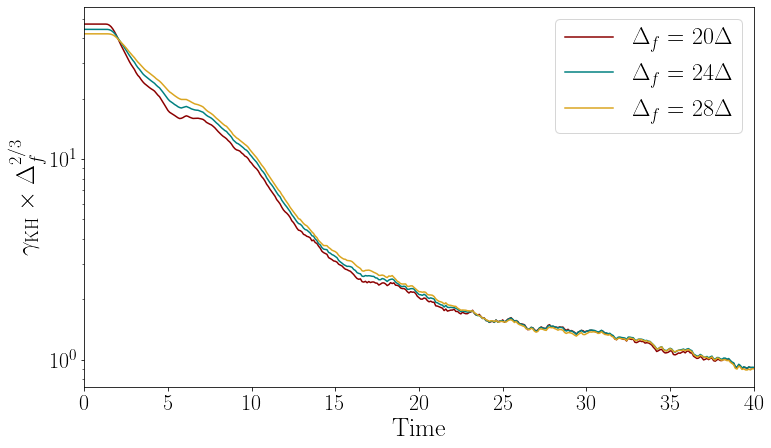

In [8]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

fig, ax = plt.subplots(figsize = (12,7))
gmean = np.mean(g_khi, axis = (2,3,4))

ax.tick_params(axis='y',labelsize = 22)
ax.tick_params(axis='x',labelsize = 22)
color = ['darkred','teal','goldenrod']

for i,ss in enumerate(Sf): 
    ax.plot(t,gmean[i,:]*int(ss)**(2/3), color = color[i],label = r'$\Delta_f=$ '+str(Sf[i])+'$\Delta$')

#ax.set_title(r'$e\propto \Delta_f^{2/3}$', fontsize =25)
ax.set_xlabel('Time', fontsize = '26')
ax.set_xlim([0,40])
ax.set_ylabel(r'$\gamma_{\rm KH}\times\Delta_f^{2/3}$',fontsize = '26')
ax.set_yscale('log')
ax.legend(loc='upper right',fontsize = '24')
plt.savefig('/home/miquelmiravet/Desktop/figs_khi/gamma_khi_sf.pdf',bbox_inches='tight')

(0.0, 40.0)

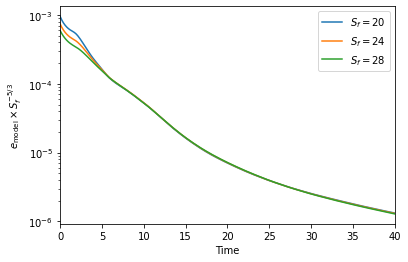

In [5]:
emod = np.mean(np.array(energyKHI), axis = (2,3,4))

for i,ss in enumerate(Sf): 
    plt.plot(t[:],emod[i,:]*int(ss)**(-5/3),label = r'$S_f = $'+ss)
#    plt.plot(t[:],emod[i,:,])
    
plt.ylabel(r'$e_{\rm model} \times S_f^{-5/3}$ ')
plt.xlabel('Time')
plt.legend()
plt.yscale('log')
plt.xlim([0,40])

(0.0, 40.0)

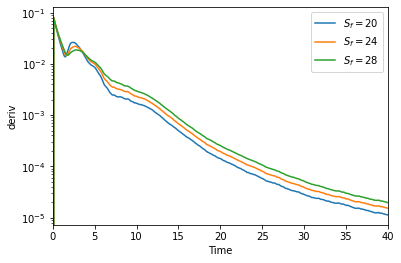

In [6]:
deriv = np.mean(deren, axis = (2,3,4))

for i,ss in enumerate(Sf): 
    plt.plot(t[:],abs(deriv[i,:]),label = r'$S_f = $'+ss)
#    plt.plot(t[:],emod[i,:,])
    
plt.ylabel('deriv')
plt.xlabel('Time')
plt.legend()
plt.yscale('log')
plt.xlim([0,40])

In [18]:
stdmean = np.mean(std, axis = (1,2,3))
for i,ss in enumerate(Sf):  
    print(stdmean[i]*int(ss))

132.30662023066765
132.30295090231914
132.3006868971315


(0.0, 40.0)

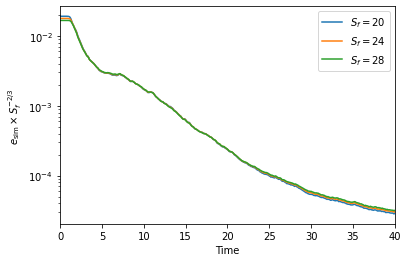

In [25]:
ekhim = np.mean(ekhi, axis = (2,3,4))
for i,ss in enumerate(Sf): 
    plt.plot(t[:],ekhim[i,:]*(int(ss))**(-2/3),label = r'$S_f = $'+ss)
    
plt.ylabel(r'$e_{\rm sim} \times S_f^{-2/3}$ ')
plt.xlabel('Time')
plt.legend()
plt.yscale('log')
plt.xlim([0,40])
#plt.ylim(top = 1e-2)

(0.0, 40.0)

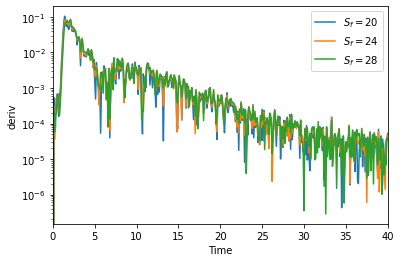

In [27]:
dersim = np.zeros((3,len(t)))

for i in range(1,len(told)):
    dersim[:,i] = (ekhim[:,i]-ekhim[:,i-1])/(t[1]-t[0])
    
for i,ss in enumerate(Sf): 
    plt.plot(t[:],abs(dersim[i,:]),label = r'$S_f = $'+ss)
#    plt.plot(t[:],emod[i,:,])
    
plt.ylabel('deriv')
plt.xlabel('Time')
plt.legend()
plt.yscale('log')
plt.xlim([0,40])    

In [ ]:
gint = np.mean(gmod, axis = (2,3,4))

for i,ss in enumerate(Sf):
  #  plt.plot(told[:],gmean[i,:]*(int(ss)/20)**(2/3),label = r'$S_f = $'+ss)
    plt.plot(tnew[:],gint[i,:]*(int(ss)/20)**(2/3),label = r'$S_f = $'+ss)
    
plt.ylabel('gamma')
plt.xlabel('Time')
plt.legend()
plt.yscale('log')
plt.xlim([0,40])

(0.0, 40.0)

(25.0, 40.0)

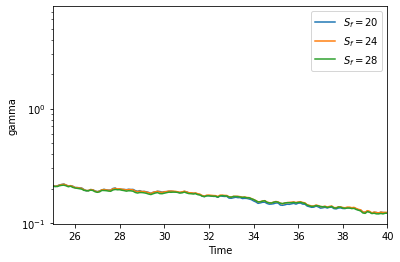

In [41]:
gmean = np.mean(g_khi, axis = (2,3,4))

for i,ss in enumerate(Sf):
    plt.plot(told[:],gmean[i,:]*(int(ss)/20)**(2/3),label = r'$S_f = $'+ss)
#    plt.plot(told[:],gmean[i,:],label = r'$S_f = $'+ss)
    
plt.ylabel('gamma')
plt.xlabel('Time')
plt.legend()
plt.yscale('log')
plt.xlim([0,40])

In [24]:
g24 = gmean[0]*(int(Sf[0])/24)**(2/3)

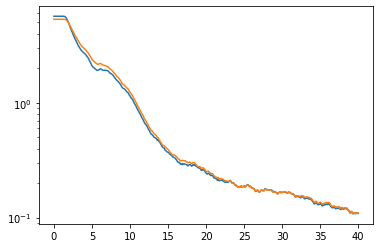

In [25]:
plt.plot(told, g24)
plt.plot(told, gmean[1])
plt.yscale('log')